# 下準備

## PyTorchのインストール

In [0]:
!pip install torch torchvision

## 必要なパッケージのインポート

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

##  transformを定義する



In [0]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## 学習データと検証データの用意

In [0]:
# 学習データ
train_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=4,shuffle=True, num_workers=2)
# 検証データ
test_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size=4,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## クラスの中身を設定する

In [0]:
class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 調理手順

## 必要なパッケージのインポート

In [0]:
import matplotlib.pyplot as plt
import numpy as np

## 画像を表示する関数

In [0]:
def show_image(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## CIFAR10の中身を見る

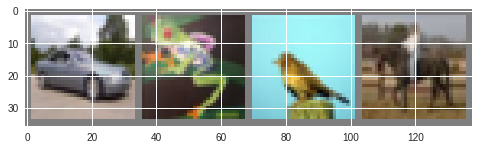

  car  frog  bird horse


In [0]:
# 学習データからちょっとデータを取ってきます
data_iterator = iter(train_data_loader)
images, labels = data_iterator.next()

# 画像を表示します
show_image(torchvision.utils.make_grid(images))
# ラベルを表示します
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

## 学習のニューラルネットワークの定義



In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.layer1 = nn.Linear(16 * 5 * 5, 120)
    self.layer2 = nn.Linear(120, 84)
    self.layer3 = nn.Linear(84, 10)

  def forward(self, input_data):
    input_data = self.pool(F.relu(self.conv1(input_data)))
    input_data = self.pool(F.relu(self.conv2(input_data)))
    input_data = input_data.view(-1, 16 * 5 * 5)
    input_data = F.relu(self.layer1(input_data))
    input_data = F.relu(self.layer2(input_data))
    input_data = self.layer3(input_data)
    return input_data

model = CNN()

## optimizerの設定

In [0]:
import torch.optim as optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 学習

In [0]:
# 最大学習回数
MAX_EPOCH = 3

#
for epoch in range(MAX_EPOCH):

  total_loss = 0.0
  for i, data in enumerate(train_data_loader, 0):
    # dataから学習対象データと教師ラベルデータを取り出します
    train_data, teacher_labels = data

    # 計算された勾配情報を削除します
    optimizer.zero_grad()

    # モデルでの予測を計算します
    outputs = model(train_data)
    
    # lossとwによる微分計算します
    loss = criterion(outputs, teacher_labels)
    loss.backward()
    
    # 勾配を更新します
    optimizer.step()

    # 誤差を累計します
    total_loss += loss.item()
    
    # 2000ミニバッチずつ、進捗を表示します
    if i % 2000 == 1999:
      print('学習進捗：[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, total_loss / 2000))
      total_loss = 0.0

print('学習完了')

学習進捗：[1,  2000] loss: 2.231
学習進捗：[1,  4000] loss: 1.875
学習進捗：[1,  6000] loss: 1.725
学習進捗：[1,  8000] loss: 1.614
学習進捗：[1, 10000] loss: 1.540
学習進捗：[1, 12000] loss: 1.481
学習進捗：[2,  2000] loss: 1.418
学習進捗：[2,  4000] loss: 1.366
学習進捗：[2,  6000] loss: 1.324
学習進捗：[2,  8000] loss: 1.304
学習進捗：[2, 10000] loss: 1.308
学習進捗：[2, 12000] loss: 1.261
学習進捗：[3,  2000] loss: 1.192
学習進捗：[3,  4000] loss: 1.218
学習進捗：[3,  6000] loss: 1.187
学習進捗：[3,  8000] loss: 1.162
学習進捗：[3, 10000] loss: 1.180
学習進捗：[3, 12000] loss: 1.161
学習完了


## 個別データで検証

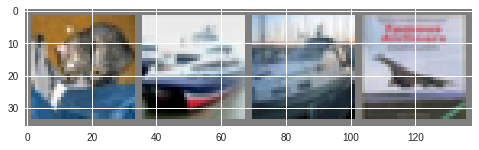

正解教師ラベル:    cat  ship  ship plane


In [0]:
data_iterator = iter(test_data_loader)
images, labels = data_iterator.next()

# 画像を表示します
show_image(torchvision.utils.make_grid(images))
print('正解教師ラベル: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

## テスト

In [0]:
outputs = model(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('予測: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))

予測:   frog  ship  ship  ship


## 検証

In [0]:
count_when_correct = 0
total = 0
with torch.no_grad():
  for data in test_data_loader:
    test_data, teacher_labels = data
    results = model(test_data)
    _, predicted = torch.max(results.data, 1)
    total += teacher_labels.size(0)
    count_when_correct += (predicted == teacher_labels).sum().item()

print('10000 検証画像に対しての正解率: %d %%' % (100 * count_when_correct / total))

10000 検証画像に対しての正解率: 58 %


## クラス毎の検証結果

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
#
with torch.no_grad():
  for data in test_data_loader:
    #  
    test_data, teacher_labels = data
    #
    results = model(test_data)
    #
    _, predicted = torch.max(results, 1)
    #
    c = (predicted == teacher_labels).squeeze()
    #
    for i in range(4):
      label = teacher_labels[i]
      #
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print(' %5s クラスの正解率は: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

 plane クラスの正解率は: 50 %
   car クラスの正解率は: 68 %
  bird クラスの正解率は: 44 %
   cat クラスの正解率は: 46 %
  deer クラスの正解率は: 52 %
   dog クラスの正解率は: 47 %
  frog クラスの正解率は: 82 %
 horse クラスの正解率は: 63 %
  ship クラスの正解率は: 79 %
 truck クラスの正解率は: 53 %
